# Alice's Workspace for Final Project

In [1]:
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [6]:
!pwd

/media/notebooks/w261_final_project/misc_code


In [ ]:
# global vars (paths) - ADJUST AS NEEDED
JAR_FILE = "/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.0.jar"
HDFS_DIR = "/user/root/final_project"
#!pwd
HOME_DIR = "/media/notebooks/w261_final_project/misc_code" 

In [ ]:
# save path for use in Hadoop jobs (-cmdenv PATH={PATH})
from os import environ
PATH  = environ['PATH']

In [ ]:
# data path
ENRON = "data/enronemail_1h.txt"

#### Setup Spark Session

In [2]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "FinalProject_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

#### Load data

In [141]:
# create dataframe from train_0005.tsv
df = spark.read.csv('../data/train_005.tsv', sep='\t')

## EDA

#### 1. Take a first look at the data

In [142]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: string (nullable = true)
 |-- _c25: string (nullable = true)
 |-- _c26: string (nullable = true)
 |-- _c27: string (nullable = tru

##### All of them are in string. We know some columns are numerical variables. We need to fix that later

In [145]:
traindf.head(3)

[Row(_c0='0', _c1=None, _c2='-1', _c3=None, _c4=None, _c5=None, _c6=None, _c7=None, _c8=None, _c9=None, _c10=None, _c11=None, _c12=None, _c13=None, _c14='05db9164', _c15='38a947a1', _c16='4093220a', _c17='6a14f9b9', _c18='43b19349', _c19='7e0ccccf', _c20='3ffb655b', _c21='1f89b562', _c22='7cc72ec2', _c23='3b08e48b', _c24='d3246de4', _c25='002ec9ad', _c26='31078fbf', _c27='07d13a8f', _c28='586a2aab', _c29='f8b34416', _c30='2005abd1', _c31='e5f8f18f', _c32=None, _c33=None, _c34='f3ddd519', _c35=None, _c36='be7c41b4', _c37='b34f3128', _c38=None, _c39=None),
 Row(_c0='0', _c1=None, _c2='-1', _c3=None, _c4=None, _c5=None, _c6=None, _c7=None, _c8=None, _c9=None, _c10=None, _c11=None, _c12=None, _c13=None, _c14='05db9164', _c15='38a947a1', _c16='c94dc713', _c17='7686d73f', _c18='25c83c98', _c19='fbad5c96', _c20='bcf6609d', _c21='0b153874', _c22='7cc72ec2', _c23='3b08e48b', _c24='bf47c6ee', _c25='c0c9a369', _c26='208257bb', _c27='07d13a8f', _c28='6d4ff9ff', _c29='3759ec50', _c30='2005abd1', _c

##### There is no column names and the values are all converted to bitwise info.

In [159]:
traindf.describe().show()

+-------+-------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+--------+--------+--------+--------+--------------------+--------+--------+--------------------+--------+--------+--------+--------+--------+--------------------+--------+--------+---------+--------+--------+--------+--------+--------+-----------+--------+---------+--------+
|summary|                _c0|               _c1|               _c2|               _c3|              _c4|              _c5|               _c6|              _c7|               _c8|               _c9|              _c10|             _c11|              _c12|              _c13|    _c14|    _c15|    _c16|    _c17|                _c18|    _c19|    _c20|                _c21|    _c22|    _c23|    _c24|    _c25|    _c26|                _c27|    _c28|    _c29|

__Based on the description from the competition and also the description above, we know that column 0-13 are integer values, column 14-39 are categorical values. There is no column that has zero valid data.__

In [148]:
from pyspark.sql.types import *
def convertColumn(df, names, newType):
    for name in names: 
        df = df.withColumn(name, df[name].cast(newType))
    return df 

In [178]:
numerical_col = ['_c0', '_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8', '_c9', '_c10', '_c11', '_c12', '_c13']

In [179]:
df = convertColumn(df, numerical_col, FloatType())

In [150]:
df.printSchema()

root
 |-- _c0: float (nullable = true)
 |-- _c1: float (nullable = true)
 |-- _c2: float (nullable = true)
 |-- _c3: float (nullable = true)
 |-- _c4: float (nullable = true)
 |-- _c5: float (nullable = true)
 |-- _c6: float (nullable = true)
 |-- _c7: float (nullable = true)
 |-- _c8: float (nullable = true)
 |-- _c9: float (nullable = true)
 |-- _c10: float (nullable = true)
 |-- _c11: float (nullable = true)
 |-- _c12: float (nullable = true)
 |-- _c13: float (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: string (nullable = true)
 |-- _c25: string (nullable = true)
 |-- _c26: string (nullable = true)
 |-- _c27: string (nullable = true)
 |-- _c28: 

### 2. Df is corrected ->  train/test split

In [151]:
splits = df.randomSplit([0.2, 0.8], seed=2615)
testdf = splits[0]
traindf = splits[1]

#### Label distribution

In [40]:
testdf.groupBy("_c0").count().show()

+---+-----+
|_c0|count|
+---+-----+
|  0| 3455|
|  1| 1123|
+---+-----+



In [132]:
traindf.groupBy("_c0").count().show()

+---+-----+
|_c0|count|
+---+-----+
|  0|13602|
|  1| 4777|
+---+-----+



#### There's about 25% of label 1 and 75% of label 0 in both train/test set. We do not have a balanced dataset. However, the imbalance is also not as extreme as say fraud detection that may be just under 10% of the samples.

In [111]:
columns = traindf.columns[1:]
distinct_count = []
for col in columns:
    distinct_count.append(traindf.select(col).distinct().count())

In [116]:
for col, count in zip(columns, distinct_count):
    print (col, ":", count)

_c1 : 91
_c2 : 1188
_c3 : 317
_c4 : 68
_c5 : 8442
_c6 : 943
_c7 : 360
_c8 : 61
_c9 : 987
_c10 : 9
_c11 : 69
_c12 : 45
_c13 : 102
_c14 : 230
_c15 : 439
_c16 : 10305
_c17 : 6978
_c18 : 83
_c19 : 10
_c20 : 4497
_c21 : 129
_c22 : 3
_c23 : 4842
_c24 : 2683
_c25 : 9644
_c26 : 2184
_c27 : 25
_c28 : 2812
_c29 : 8588
_c30 : 9
_c31 : 1540
_c32 : 702
_c33 : 4
_c34 : 9202
_c35 : 10
_c36 : 14
_c37 : 4061
_c38 : 45
_c39 : 3117


In [174]:
! pip install pyspark_dist_explore

distributed 1.22.0 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [186]:
traindf_num = traindf.select(numerical_col)

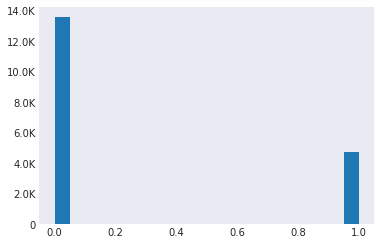

In [189]:
from pyspark_dist_explore import hist
fig, ax = plt.subplots()
for col in numerical_col:
    hist(ax, traindf_num.select(col), bins = 20)
    plt.show()

In [122]:
from pyspark.mllib.stat import Statistics

In [126]:
traindf.filter(lambda x:x[0] == '0').values()

TypeError: condition should be string or Column

In [124]:
Statistics.colStats(traindf.filter(lambda x: x[0] == str(1)).values())

TypeError: condition should be string or Column

In [128]:
Statistics.colStats(traindf.select('_c0'))

AttributeError: 'DataFrame' object has no attribute 'map'

In [134]:
Statistics.colStats(traindf.select('_c0'))

AttributeError: 'DataFrame' object has no attribute 'map'

##### Columns

In [54]:
for col in df.columns[1:]:
    traindf.groupBy(col).count().show()

+---+-----+
|_c1|count|
+---+-----+
| 49|    1|
| 48|    1|
| 79|    1|
| 81|    1|
| 58|    1|
| 67|    1|
| 84|    1|
|130|    1|
|111|    1|
| 92|    1|
|171|    1|
| 75|    1|
| 61|    1|
|112|    1|
|195|    1|
| 77|    1|
| 70|    1|
|128|    1|
| 90|    1|
| 59|    1|
+---+-----+
only showing top 20 rows

+----+-----+
| _c2|count|
+----+-----+
|1043|    1|
|2915|    1|
|3057|    1|
|1773|    1|
|3179|    1|
| 470|    1|
| 574|    1|
|2034|    1|
|1512|    1|
| 577|    1|
| 447|    1|
|2888|    1|
| 691|    1|
|1241|    1|
|2530|    1|
| 870|    1|
|2069|    1|
| 711|    1|
| 743|    1|
|1349|    1|
+----+-----+
only showing top 20 rows

+----+-----+
| _c3|count|
+----+-----+
|2000|    1|
|1514|    1|
|7370|    1|
| 348|    1|
| 559|    1|
| 356|    1|
|3605|    1|
| 388|    1|
| 200|    1|
| 459|    1|
| 282|    1|
| 155|    1|
| 788|    1|
| 740|    1|
| 171|    1|
| 317|    1|
| 296|    1|
| 383|    1|
| 323|    1|
| 234|    1|
+----+-----+
only showing top 20 rows

+---+-----

In [47]:
df.head(2)

[Row(_c0='0', _c1='0', _c2='1', _c3='10', _c4='2', _c5='4851', _c6='139', _c7='7', _c8='2', _c9='53', _c10='0', _c11='1', _c12=None, _c13='2', _c14='05db9164', _c15='403ea497', _c16='2cbec47f', _c17='3e2bfbda', _c18='25c83c98', _c19=None, _c20='866e2a5e', _c21='5b392875', _c22='a73ee510', _c23='3b08e48b', _c24='a15790a3', _c25='21a23bfe', _c26='a0abbb5b', _c27='07d13a8f', _c28='e3209fc2', _c29='587267a3', _c30='d4bb7bd8', _c31='a78bd508', _c32='21ddcdc9', _c33='5840adea', _c34='c2a93b37', _c35=None, _c36='3a171ecb', _c37='1793a828', _c38='e8b83407', _c39='2fede552'),
 Row(_c0='0', _c1='0', _c2='93', _c3='21', _c4='21', _c5='2387', _c6='73', _c7='7', _c8='24', _c9='174', _c10='0', _c11='6', _c12=None, _c13='21', _c14='05db9164', _c15='421b43cd', _c16='e8c51b7b', _c17='29998ed1', _c18='25c83c98', _c19='fe6b92e5', _c20='dc7659bd', _c21='0b153874', _c22='a73ee510', _c23='fed0f64c', _c24='e51ddf94', _c25='6aaba33c', _c26='3516f6e6', _c27='b28479f6', _c28='e1ac77f7', _c29='b041b04a', _c30='e

In [20]:
df.head(2)

[Row(_c0='0', _c1='0', _c2='1', _c3='10', _c4='2', _c5='4851', _c6='139', _c7='7', _c8='2', _c9='53', _c10='0', _c11='1', _c12=None, _c13='2', _c14='05db9164', _c15='403ea497', _c16='2cbec47f', _c17='3e2bfbda', _c18='25c83c98', _c19=None, _c20='866e2a5e', _c21='5b392875', _c22='a73ee510', _c23='3b08e48b', _c24='a15790a3', _c25='21a23bfe', _c26='a0abbb5b', _c27='07d13a8f', _c28='e3209fc2', _c29='587267a3', _c30='d4bb7bd8', _c31='a78bd508', _c32='21ddcdc9', _c33='5840adea', _c34='c2a93b37', _c35=None, _c36='3a171ecb', _c37='1793a828', _c38='e8b83407', _c39='2fede552'),
 Row(_c0='0', _c1='0', _c2='93', _c3='21', _c4='21', _c5='2387', _c6='73', _c7='7', _c8='24', _c9='174', _c10='0', _c11='6', _c12=None, _c13='21', _c14='05db9164', _c15='421b43cd', _c16='e8c51b7b', _c17='29998ed1', _c18='25c83c98', _c19='fe6b92e5', _c20='dc7659bd', _c21='0b153874', _c22='a73ee510', _c23='fed0f64c', _c24='e51ddf94', _c25='6aaba33c', _c26='3516f6e6', _c27='b28479f6', _c28='e1ac77f7', _c29='b041b04a', _c30='e

In [26]:
testdf.count()

18379

In [73]:
# rename columns from default _c0,_c1... _c26 to ['Label','I0'..[C0]]
# per the readme.
# just run this one once, or reload the data first to run again
old_col_names=df_0005.columns
new_col_names = ['Label']+['I{}'.format(i) for i in range(0,13)]+['C{}'.format(i) for i in range(0,26)]
for old_name,new_name in zip(old_col_names,new_col_names):
    df_0005 = df_0005.withColumnRenamed(old_name,new_name)
# We should probably cast the data now, didn't get this working yet
#   df_0005 = joindf.withcolumn(new_name,joindf(new_name).cast("double"))
df_0005.head(20)

[Row(Label='0', I0='0', I1='1', I2='10', I3='2', I4='4851', I5='139', I6='7', I7='2', I8='53', I9='0', I10='1', I11=None, I12='2', C0='05db9164', C1='403ea497', C2='2cbec47f', C3='3e2bfbda', C4='25c83c98', C5=None, C6='866e2a5e', C7='5b392875', C8='a73ee510', C9='3b08e48b', C10='a15790a3', C11='21a23bfe', C12='a0abbb5b', C13='07d13a8f', C14='e3209fc2', C15='587267a3', C16='d4bb7bd8', C17='a78bd508', C18='21ddcdc9', C19='5840adea', C20='c2a93b37', C21=None, C22='3a171ecb', C23='1793a828', C24='e8b83407', C25='2fede552'),
 Row(Label='0', I0='0', I1='93', I2='21', I3='21', I4='2387', I5='73', I6='7', I7='24', I8='174', I9='0', I10='6', I11=None, I12='21', C0='05db9164', C1='421b43cd', C2='e8c51b7b', C3='29998ed1', C4='25c83c98', C5='fe6b92e5', C6='dc7659bd', C7='0b153874', C8='a73ee510', C9='fed0f64c', C10='e51ddf94', C11='6aaba33c', C12='3516f6e6', C13='b28479f6', C14='e1ac77f7', C15='b041b04a', C16='e5ba7672', C17='2804effd', C18=None, C19=None, C20='723b4dfd', C21=None, C22='3a171ecb',

In [84]:
from pyspark.sql.functions import countDistinct,col
df_counts = df_0005.agg(*(countDistinct(col(c)).alias(c) for c in df_0005.columns)).show()
df_counts.show()

+-----+---+----+---+---+----+----+---+---+----+---+---+---+---+---+---+-----+----+---+---+----+---+---+----+----+-----+----+---+----+-----+---+----+---+---+-----+---+---+----+---+----+
|Label| I0|  I1| I2| I3|  I4|  I5| I6| I7|  I8| I9|I10|I11|I12| C0| C1|   C2|  C3| C4| C5|  C6| C7| C8|  C9| C10|  C11| C12|C13| C14|  C15|C16| C17|C18|C19|  C20|C21|C22| C23|C24| C25|
+-----+---+----+---+---+----+----+---+---+----+---+---+---+---+---+---+-----+----+---+---+----+---+---+----+----+-----+----+---+----+-----+---+----+---+---+-----+---+---+----+---+----+
|    2| 95|1349|358| 70|9769|1030|392| 63|1042|  8| 70| 47|109|261|450|12574|8307| 86|  9|4987|142|  3|5481|2874|11739|2306| 25|3117|10366|  9|1684|770|  3|11156|  9| 14|4732| 44|3621|
+-----+---+----+---+---+----+----+---+---+----+---+---+---+---+---+---+-----+----+---+---+----+---+---+----+----+-----+----+---+----+-----+---+----+---+---+-----+---+---+----+---+----+

